In [45]:
%cd /home/joel/repos/cscollab/backend
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import requests
import json
from sklearn.manifold import TSNE
import pandas as pd
import kuzudb.query_kuzu as query
import numpy as np
from GNN.colormap import generate_colormap
import GNN.node_classification as nc 
import GNN.gen_dataset as dataset 
import torch

local_url = "http://127.0.0.1:8030"
server_url = "https://cscollab.ifi.uzh.ch/backend"

url_base = server_url 

plt.style.use('default')
sns.set_style("whitegrid")

/home/joel/repos/cscollab/backend


In [40]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    NUM_COLORS = len(np.unique(color))
    cmap = generate_colormap(NUM_COLORS) if NUM_COLORS > 10 else "Set3"
    fig = plt.figure(figsize=(5,5))
    plt.xticks([])
    plt.yticks([])
    # cm = plt.get_cmap('gist_rainbow')
    # ax = fig.add_subplot(111)
    # ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color,cmap=cmap)
    plt.show()

In [18]:
area_mapping = query.get_area_mapping()
sub_area_ids = list(area_mapping["sub-area-id"].unique())

In [11]:
# load positions for dach
url = url_base+"/api/gcn/get_node_position"
config = { "from_year": 2015,
            "region_ids":["dach"],
            "strict_boundary":True,
            "institution":False}
use_sub_areas = True
input = {"config": json.dumps(config),
         "sub_areas":use_sub_areas}
x = requests.post(url, json = input)
node_position = json.loads(x.content)
print(len(node_position))

853


In [12]:
url = url_base+"/api/db/get_frequency_research_field"
config = { "from_year": 2015,
            "region_ids":["dach"],
            "strict_boundary":True,
            "institution":False}
input = {"config": json.dumps(config)}
x = requests.post(url, json = input)
freq = json.loads(x.content)
print(len(freq))

853


In [20]:
nodes = list(node_position.keys())
x = list(map(lambda x: node_position[x]["x"], nodes))
y = list(map(lambda x: node_position[x]["y"], nodes))
top_subarea = list(map(lambda x: freq[x]["subarea"]["top"], nodes))
top_subarea_idx = list(map(lambda x: sub_area_ids.index(x),top_subarea))

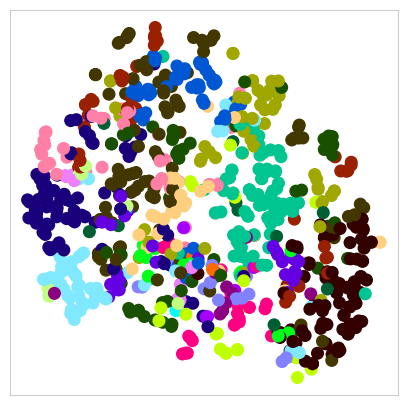

In [21]:
color = top_subarea_idx

NUM_COLORS = len(np.unique(color))
cmap = generate_colormap(NUM_COLORS) if NUM_COLORS > 10 else "Set3"
fig = plt.figure(figsize=(5,5))
plt.xticks([])
plt.yticks([])
plt.scatter(x, y, s=70, c=color,cmap=cmap)
plt.show()

In [49]:
def get_position(model, data):
    model.eval()
    out = model(data)
    node_idx, node_ids = data.node_mapping
    idx_node_mapping = dict(zip(node_idx,node_ids))
    """use T-distributed Stochastic Neighbor Embedding to visualize high-dimensional data"""
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
    node_positions = dict(zip(  list(map(lambda x: idx_node_mapping[x], range(data.num_nodes))),
                                list(map(lambda i: {"x":np.float64(z[i,0]),"y":np.float64(z[i,1])} , range(data.num_nodes)))))
    return node_positions  

In [50]:
data = dataset.get_torch_data(config, True ,use_cache=False)
model = nc.author_subarea_model(data)
positions = get_position(model,data)

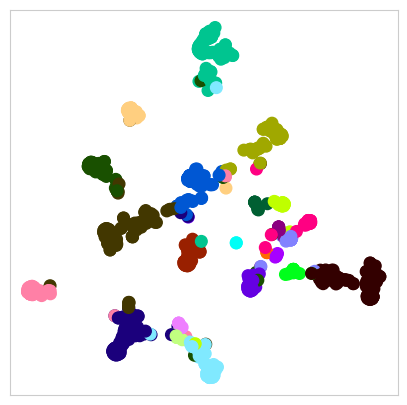

In [44]:
model.eval()
out = model(data)
visualize(out, color=data.y)

In [51]:
nodes_loc = list(positions.keys())
x_loc = list(map(lambda x: positions[x]["x"], nodes_loc))
y_loc = list(map(lambda x: positions[x]["y"], nodes_loc))
top_subarea_loc = list(map(lambda x: freq[x]["subarea"]["top"], nodes_loc))
top_subarea_idx_loc = list(map(lambda x: sub_area_ids.index(x),top_subarea_loc))
len(nodes_loc)

853

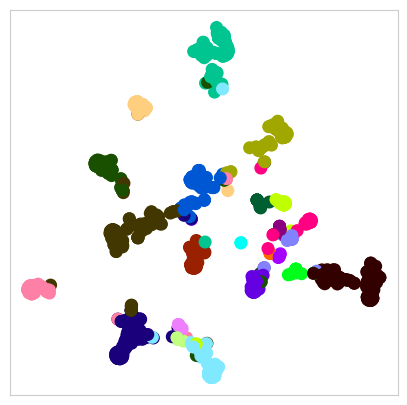

In [52]:
color = top_subarea_idx_loc

NUM_COLORS = len(np.unique(color))
cmap = generate_colormap(NUM_COLORS) if NUM_COLORS > 10 else "Set3"
fig = plt.figure(figsize=(5,5))
plt.xticks([])
plt.yticks([])
plt.scatter(x_loc, y_loc, s=70, c=color,cmap=cmap)
plt.show()

In [37]:
config = { "from_year": 2015,
            "region_ids":["dach"],
            "strict_boundary":True,
            "institution":False}
data_dach = dataset.get_torch_data(config, True,use_cache=False)
data_dach

Data(x=[853, 23], edge_index=[2, 3339], y=[853], num_nodes=853, edge_weight=[3339], node_mapping=[2], train_mask=[853], val_mask=[853], test_mask=[853])

In [38]:
model_wd = nc.GCN(hidden_channels=16,data=data_dach)
nc.test(model_wd,data_dach)
model_wd.load_state_dict(torch.load("GNN/GCN_wd_subarea_weights.pth"))
nc.test(model_wd,data_dach)

0.9460726846424384

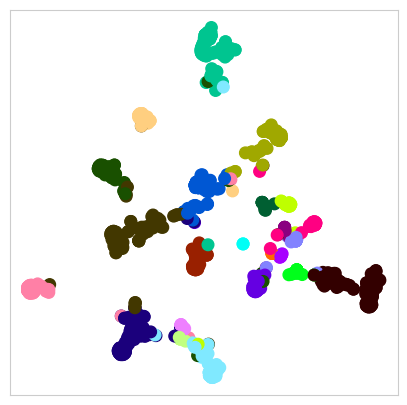

In [41]:
model_wd.eval()
out = model_wd(data_dach)
visualize(out, color=data_dach.y)